# START 2

### Обработка данных

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [2]:
train_df = pd.read_parquet("./Alfa_Bank/train_data.pqt")
test_df = pd.read_parquet("./Alfa_Bank/test_data.pqt")

In [3]:
train_df.head(5)

,id,date,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,...,cnt_cred_g_oper_3m,cnt_days_cred_g_oper_3m,sum_deb_h_oper_3m,cnt_deb_h_oper_3m,cnt_days_deb_h_oper_3m,sum_cred_h_oper_3m,cnt_cred_h_oper_3m,cnt_days_cred_h_oper_3m,start_cluster,end_cluster
0,0,month_1,0.744845,0.705492,1.287207,0.748101,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.951166,0.568681,0.897565,0.553624,0.774354,0.936506,0.295984,0.967947,"{α, γ}",{other}
1,0,month_2,1.049605,0.831916,2.458609,1.053805,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.948812,0.499716,0.785029,0.551904,0.696576,0.990157,0.298873,0.945969,"{α, γ}",{other}
2,0,month_3,0.692653,0.740253,0.430042,0.695747,channel_code_5,city_23,city_type_0,index_city_code_39,...,0.946458,0.442244,0.877050,0.551044,0.663243,0.810065,0.294829,0.956958,"{α, γ}",{other}
3,1,month_1,-0.081586,-0.091860,-0.114040,-0.080890,channel_code_2,city_14,city_type_0,None,...,0.945281,0.407762,0.369318,0.567093,0.785465,-0.184002,0.253523,0.462452,{other},{other}
4,1,month_2,-0.094962,-0.100504,-0.119302,-0.094307,channel_code_2,city_14,city_type_0,None,...,0.946066,0.430750,0.067275,0.559928,0.696576,-0.183854,0.255545,0.495419,{other},{other}


In [4]:
train_df.shape

(600000, 93)

In [5]:
test_df.shape

(290120, 92)

In [6]:
for col in train_df.columns:
    if train_df[col].dtype in ['int64', 'float64']:
        mean_val = train_df[col].mean()
        train_df[col] = train_df[col].fillna(mean_val)
    else:
        mod_val = train_df[train_df[col].notna()][col].mode()
        train_df[col] = train_df[col].fillna(mod_val[0])

for col in test_df.columns:
    if test_df[col].dtype in ['int64', 'float64']:
        mean_val = test_df[col].mean()
        test_df[col] = test_df[col].fillna(mean_val)
    else:
        mod_val = test_df[test_df[col].notna()][col].mode()
        test_df[col] = test_df[col].fillna(mod_val[0])

In [7]:
for col in train_df.columns:
    print(col, train_df[col].isna().sum())

id 0
date 0
balance_amt_avg 0
balance_amt_max 0
balance_amt_min 0
balance_amt_day_avg 0
channel_code 0
city 0
city_type 0
index_city_code 0
ogrn_days_end_month 0
ogrn_days_end_quarter 0
ogrn_month 0
ogrn_year 0
ft_registration_date 0
max_founderpres 0
min_founderpres 0
ogrn_exist_months 0
okved 0
segment 0
sum_of_paym_2m 0
sum_of_paym_6m 0
sum_of_paym_1y 0
sum_a_oper_1m 0
cnt_a_oper_1m 0
sum_b_oper_1m 0
cnt_b_oper_1m 0
sum_c_oper_1m 0
cnt_c_oper_1m 0
sum_deb_d_oper_1m 0
cnt_deb_d_oper_1m 0
sum_cred_d_oper_1m 0
cnt_cred_d_oper_1m 0
sum_deb_e_oper_1m 0
cnt_deb_e_oper_1m 0
cnt_days_deb_e_oper_1m 0
sum_cred_e_oper_1m 0
cnt_cred_e_oper_1m 0
cnt_days_cred_e_oper_1m 0
sum_deb_f_oper_1m 0
cnt_deb_f_oper_1m 0
cnt_days_deb_f_oper_1m 0
sum_cred_f_oper_1m 0
cnt_cred_f_oper_1m 0
cnt_days_cred_f_oper_1m 0
sum_deb_g_oper_1m 0
cnt_deb_g_oper_1m 0
cnt_days_deb_g_oper_1m 0
sum_cred_g_oper_1m 0
cnt_cred_g_oper_1m 0
cnt_days_cred_g_oper_1m 0
sum_deb_h_oper_1m 0
cnt_deb_h_oper_1m 0
cnt_days_deb_h_oper_1m 0

In [8]:
X = train_df.drop(["id", "date", "end_cluster"], axis=1)
y = train_df["end_cluster"]

In [9]:
# Предобработка числовых и категориальных данных
numeric_features = list(X.select_dtypes(include=['float64', 'int64']).columns)
categorical_features = list(X.select_dtypes(include=['object']).columns)

In [10]:
categorical_features

['channel_code',
 'city',
 'city_type',
 'index_city_code',
 'ogrn_month',
 'ogrn_year',
 'okved',
 'segment',
 'start_cluster']

In [11]:
for col in categorical_features[:-1]:
    X[col+'_num'] = X[col].str.split('_').str.get(-1)
    X[col+'_num'] = X[col+'_num'].astype("int64")

In [12]:
X.head()

,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,ogrn_days_end_month,ogrn_days_end_quarter,...,cnt_days_cred_h_oper_3m,start_cluster,channel_code_num,city_num,city_type_num,index_city_code_num,ogrn_month_num,ogrn_year_num,okved_num,segment_num
0,0.744845,0.705492,1.287207,0.748101,channel_code_5,city_23,city_type_0,index_city_code_39,-0.488553,-0.135063,...,0.967947,"{α, γ}",5,23,0,39,0,1,30,1
1,1.049605,0.831916,2.458609,1.053805,channel_code_5,city_23,city_type_0,index_city_code_39,-0.488553,-0.135063,...,0.945969,"{α, γ}",5,23,0,39,0,1,30,1
2,0.692653,0.740253,0.430042,0.695747,channel_code_5,city_23,city_type_0,index_city_code_39,-0.488553,-0.135063,...,0.956958,"{α, γ}",5,23,0,39,0,1,30,1
3,-0.081586,-0.091860,-0.114040,-0.080890,channel_code_2,city_14,city_type_0,index_city_code_46,0.324343,1.258747,...,0.462452,{other},2,14,0,46,5,15,5,1
4,-0.094962,-0.100504,-0.119302,-0.094307,channel_code_2,city_14,city_type_0,index_city_code_46,0.324343,1.258747,...,0.495419,{other},2,14,0,46,5,15,5,1


In [13]:
encoder = OrdinalEncoder()

In [14]:
X['start_cluster_code'] = encoder.fit_transform(X[['start_cluster']])

In [15]:
X.head()

,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,channel_code,city,city_type,index_city_code,ogrn_days_end_month,ogrn_days_end_quarter,...,start_cluster,channel_code_num,city_num,city_type_num,index_city_code_num,ogrn_month_num,ogrn_year_num,okved_num,segment_num,start_cluster_code
0,0.744845,0.705492,1.287207,0.748101,channel_code_5,city_23,city_type_0,index_city_code_39,-0.488553,-0.135063,...,"{α, γ}",5,23,0,39,0,1,30,1,3.0
1,1.049605,0.831916,2.458609,1.053805,channel_code_5,city_23,city_type_0,index_city_code_39,-0.488553,-0.135063,...,"{α, γ}",5,23,0,39,0,1,30,1,3.0
2,0.692653,0.740253,0.430042,0.695747,channel_code_5,city_23,city_type_0,index_city_code_39,-0.488553,-0.135063,...,"{α, γ}",5,23,0,39,0,1,30,1,3.0
3,-0.081586,-0.091860,-0.114040,-0.080890,channel_code_2,city_14,city_type_0,index_city_code_46,0.324343,1.258747,...,{other},2,14,0,46,5,15,5,1,0.0
4,-0.094962,-0.100504,-0.119302,-0.094307,channel_code_2,city_14,city_type_0,index_city_code_46,0.324343,1.258747,...,{other},2,14,0,46,5,15,5,1,0.0


In [22]:
X.describe()

,balance_amt_avg,balance_amt_max,balance_amt_min,balance_amt_day_avg,ogrn_days_end_month,ogrn_days_end_quarter,ft_registration_date,max_founderpres,min_founderpres,ogrn_exist_months,...,cnt_days_cred_h_oper_3m,channel_code_num,city_num,city_type_num,index_city_code_num,ogrn_month_num,ogrn_year_num,okved_num,segment_num,start_cluster_code
count,6.000000e+05,6.000000e+05,6.000000e+05,6.000000e+05,6.000000e+05,6.000000e+05,6.000000e+05,6.000000e+05,6.000000e+05,6.000000e+05,...,600000.000000,600000.000000,600000.00000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000
mean,4.713267e-18,-7.238062e-17,-3.797851e-17,-8.858099e-18,-6.068035e-17,9.509430e-18,-2.303343e-18,5.773160e-18,-2.343015e-17,4.337863e-17,...,0.456226,9.514103,405.67231,226.840982,46.818408,5.002283,10.175568,18.608365,2.222147,10.737522
std,9.437725e-01,9.437725e-01,9.437725e-01,9.437725e-01,9.734200e-01,9.734200e-01,9.735168e-01,6.638379e-01,6.638379e-01,9.734200e-01,...,0.115852,6.314319,1198.12031,960.915982,26.935768,3.542884,5.167832,17.298254,1.129318,5.965668
min,-1.567780e-01,-2.049624e-01,-1.259950e-01,-1.563145e-01,-1.649833e+00,-1.722458e+00,-1.081749e+00,-1.149405e+00,-1.075208e+00,-1.093396e+00,...,0.374540,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-1.558431e-01,-2.040361e-01,-1.258318e-01,-1.554002e-01,-8.369370e-01,-7.932512e-01,-7.327614e-01,-1.043018e-01,-1.274211e-01,-7.280810e-01,...,0.374540,5.000000,0.00000,0.000000,46.000000,2.000000,4.000000,5.000000,2.000000,3.000000
50%,-1.451170e-01,-1.797798e-01,-1.241522e-01,-1.448083e-01,-6.117751e-17,1.003586e-17,-2.590533e-01,1.211971e-17,-3.759528e-17,-2.583908e-01,...,0.440474,8.000000,25.00000,0.000000,46.000000,5.000000,10.000000,10.000000,3.000000,15.000000
75%,-3.013517e-02,-7.312532e-17,-7.579568e-02,-3.029486e-02,7.888552e-01,8.328604e-01,3.519615e-01,1.211971e-17,-3.759528e-17,3.504670e-01,...,0.456226,12.000000,114.00000,0.000000,46.000000,8.000000,14.000000,30.000000,3.000000,15.000000
max,1.542407e+02,1.174957e+02,9.145077e+01,1.547193e+02,1.834007e+00,1.800784e+00,3.032875e+00,3.376642e+00,3.592823e+00,3.029441e+00,...,1.374540,44.000000,8916.00000,7930.000000,232.000000,11.000000,20.000000,87.000000,3.000000,16.000000


In [16]:
X_num = X.drop(['channel_code', 'city', 'city_type', 'index_city_code',
             'ogrn_month', 'ogrn_year', 'okved', 'segment', 'start_cluster'], axis=1)

In [17]:
X_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 90 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   balance_amt_avg          600000 non-null  float64
 1   balance_amt_max          600000 non-null  float64
 2   balance_amt_min          600000 non-null  float64
 3   balance_amt_day_avg      600000 non-null  float64
 4   ogrn_days_end_month      600000 non-null  float64
 5   ogrn_days_end_quarter    600000 non-null  float64
 6   ft_registration_date     600000 non-null  float64
 7   max_founderpres          600000 non-null  float64
 8   min_founderpres          600000 non-null  float64
 9   ogrn_exist_months        600000 non-null  float64
 10  sum_of_paym_2m           600000 non-null  float64
 11  sum_of_paym_6m           600000 non-null  float64
 12  sum_of_paym_1y           600000 non-null  float64
 13  sum_a_oper_1m            600000 non-null  float64
 14  cnt_

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X_num, y, test_size=0.2, random_state=42)

In [20]:
X_num.columns

Index(['balance_amt_avg', 'balance_amt_max', 'balance_amt_min',
       'balance_amt_day_avg', 'ogrn_days_end_month', 'ogrn_days_end_quarter',
       'ft_registration_date', 'max_founderpres', 'min_founderpres',
       'ogrn_exist_months', 'sum_of_paym_2m', 'sum_of_paym_6m',
       'sum_of_paym_1y', 'sum_a_oper_1m', 'cnt_a_oper_1m', 'sum_b_oper_1m',
       'cnt_b_oper_1m', 'sum_c_oper_1m', 'cnt_c_oper_1m', 'sum_deb_d_oper_1m',
       'cnt_deb_d_oper_1m', 'sum_cred_d_oper_1m', 'cnt_cred_d_oper_1m',
       'sum_deb_e_oper_1m', 'cnt_deb_e_oper_1m', 'cnt_days_deb_e_oper_1m',
       'sum_cred_e_oper_1m', 'cnt_cred_e_oper_1m', 'cnt_days_cred_e_oper_1m',
       'sum_deb_f_oper_1m', 'cnt_deb_f_oper_1m', 'cnt_days_deb_f_oper_1m',
       'sum_cred_f_oper_1m', 'cnt_cred_f_oper_1m', 'cnt_days_cred_f_oper_1m',
       'sum_deb_g_oper_1m', 'cnt_deb_g_oper_1m', 'cnt_days_deb_g_oper_1m',
       'sum_cred_g_oper_1m', 'cnt_cred_g_oper_1m', 'cnt_days_cred_g_oper_1m',
       'sum_deb_h_oper_1m', 'cnt_deb_h_

In [21]:
numeric_features

['balance_amt_avg',
 'balance_amt_max',
 'balance_amt_min',
 'balance_amt_day_avg',
 'ogrn_days_end_month',
 'ogrn_days_end_quarter',
 'ft_registration_date',
 'max_founderpres',
 'min_founderpres',
 'ogrn_exist_months',
 'sum_of_paym_2m',
 'sum_of_paym_6m',
 'sum_of_paym_1y',
 'sum_a_oper_1m',
 'cnt_a_oper_1m',
 'sum_b_oper_1m',
 'cnt_b_oper_1m',
 'sum_c_oper_1m',
 'cnt_c_oper_1m',
 'sum_deb_d_oper_1m',
 'cnt_deb_d_oper_1m',
 'sum_cred_d_oper_1m',
 'cnt_cred_d_oper_1m',
 'sum_deb_e_oper_1m',
 'cnt_deb_e_oper_1m',
 'cnt_days_deb_e_oper_1m',
 'sum_cred_e_oper_1m',
 'cnt_cred_e_oper_1m',
 'cnt_days_cred_e_oper_1m',
 'sum_deb_f_oper_1m',
 'cnt_deb_f_oper_1m',
 'cnt_days_deb_f_oper_1m',
 'sum_cred_f_oper_1m',
 'cnt_cred_f_oper_1m',
 'cnt_days_cred_f_oper_1m',
 'sum_deb_g_oper_1m',
 'cnt_deb_g_oper_1m',
 'cnt_days_deb_g_oper_1m',
 'sum_cred_g_oper_1m',
 'cnt_cred_g_oper_1m',
 'cnt_days_cred_g_oper_1m',
 'sum_deb_h_oper_1m',
 'cnt_deb_h_oper_1m',
 'cnt_days_deb_h_oper_1m',
 'sum_cred_h_oper_

In [23]:
numeric_features_without_start_cluster_code = ['balance_amt_avg', 'balance_amt_max', 'balance_amt_min',
       'balance_amt_day_avg', 'ogrn_days_end_month', 'ogrn_days_end_quarter',
       'ft_registration_date', 'max_founderpres', 'min_founderpres',
       'ogrn_exist_months', 'sum_of_paym_2m', 'sum_of_paym_6m',
       'sum_of_paym_1y', 'sum_a_oper_1m', 'cnt_a_oper_1m', 'sum_b_oper_1m',
       'cnt_b_oper_1m', 'sum_c_oper_1m', 'cnt_c_oper_1m', 'sum_deb_d_oper_1m',
       'cnt_deb_d_oper_1m', 'sum_cred_d_oper_1m', 'cnt_cred_d_oper_1m',
       'sum_deb_e_oper_1m', 'cnt_deb_e_oper_1m', 'cnt_days_deb_e_oper_1m',
       'sum_cred_e_oper_1m', 'cnt_cred_e_oper_1m', 'cnt_days_cred_e_oper_1m',
       'sum_deb_f_oper_1m', 'cnt_deb_f_oper_1m', 'cnt_days_deb_f_oper_1m',
       'sum_cred_f_oper_1m', 'cnt_cred_f_oper_1m', 'cnt_days_cred_f_oper_1m',
       'sum_deb_g_oper_1m', 'cnt_deb_g_oper_1m', 'cnt_days_deb_g_oper_1m',
       'sum_cred_g_oper_1m', 'cnt_cred_g_oper_1m', 'cnt_days_cred_g_oper_1m',
       'sum_deb_h_oper_1m', 'cnt_deb_h_oper_1m', 'cnt_days_deb_h_oper_1m',
       'sum_cred_h_oper_1m', 'cnt_cred_h_oper_1m', 'cnt_days_cred_h_oper_1m',
       'sum_a_oper_3m', 'cnt_a_oper_3m', 'sum_b_oper_3m', 'cnt_b_oper_3m',
       'sum_c_oper_3m', 'cnt_c_oper_3m', 'sum_deb_d_oper_3m',
       'cnt_deb_d_oper_3m', 'sum_cred_d_oper_3m', 'cnt_cred_d_oper_3m',
       'sum_deb_e_oper_3m', 'cnt_deb_e_oper_3m', 'cnt_days_deb_e_oper_3m',
       'sum_cred_e_oper_3m', 'cnt_cred_e_oper_3m', 'cnt_days_cred_e_oper_3m',
       'sum_deb_f_oper_3m', 'cnt_deb_f_oper_3m', 'cnt_days_deb_f_oper_3m',
       'sum_cred_f_oper_3m', 'cnt_cred_f_oper_3m', 'cnt_days_cred_f_oper_3m',
       'sum_deb_g_oper_3m', 'cnt_deb_g_oper_3m', 'cnt_days_deb_g_oper_3m',
       'sum_cred_g_oper_3m', 'cnt_cred_g_oper_3m', 'cnt_days_cred_g_oper_3m',
       'sum_deb_h_oper_3m', 'cnt_deb_h_oper_3m', 'cnt_days_deb_h_oper_3m',
       'sum_cred_h_oper_3m', 'cnt_cred_h_oper_3m', 'cnt_days_cred_h_oper_3m',
       'channel_code_num', 'city_num', 'city_type_num', 'index_city_code_num',
       'ogrn_month_num', 'ogrn_year_num', 'okved_num', 'segment_num']

In [24]:
# Создание предобработчика для числовых данных
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Создание комбинированного предобработчика
preprocessor_num = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features_without_start_cluster_code),
#         ('cat', 'passthrough', categorical_features)  # 'passthrough' означает, что категориальные данные останутся без изменений
    ])

In [19]:
# # Создание предобработчика для числовых данных
# numeric_transformer = Pipeline(steps=[
#     ('scaler', StandardScaler())
# ])

# # Создание комбинированного предобработчика
# preprocessor_num = ColumnTransformer(
#     transformers=[
#         ('num', numeric_transformer, numeric_features),
# #         ('cat', 'passthrough', categorical_features)  # 'passthrough' означает, что категориальные данные останутся без изменений
#     ])

In [25]:
# Преобразование данных с использованием предобработчика
X_train_processed = preprocessor_num.fit_transform(X_train)
X_val_processed = preprocessor_num.transform(X_val)

In [26]:
type(X_train_processed)

numpy.ndarray

In [27]:
# Преобразование таргета в тензоры PyTorch
label_encoder = LabelEncoder()
y_train_encoded = torch.tensor(label_encoder.fit_transform(y_train), dtype=torch.long)
y_val_encoded = torch.tensor(label_encoder.transform(y_val), dtype=torch.long)

In [28]:
X_train_tensor = torch.Tensor(X_train_processed)
X_val_tensor = torch.Tensor(X_val_processed)

In [29]:
# Преобразование данных в TensorDataset
train_dataset = TensorDataset(X_train_tensor.to_dense(), y_train_encoded.long())
test_dataset = TensorDataset(X_val_tensor.to_dense(), y_val_encoded.long())

# Загрузка данных в DataLoader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Создание модели

In [30]:
class Classifier_17(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(Classifier_17, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.softmax(x)
        return x

In [31]:
X_train_tensor.shape[1]

89

In [32]:
# Предположим, что input_size - это размер входных признаков, например, X_train_tensor.shape[1]
input_size = X_train_tensor.shape[1]
hidden_size1 = 350 # Размер первого скрытого слоя (можно настраивать)
hidden_size2 = 350   # Размер второго скрытого слоя (можно настраивать)
output_size = 17    # Количество классов

# Инициализация модели
model = Classifier_17(input_size, hidden_size1, hidden_size2, output_size)

In [39]:
LR = 0.25

# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LR)

# optimizer = optim.Adam(model.parameters(), lr=LR)

In [138]:
# # Пример использования модели на данных
# # Входные данные
# sample_input = X_train_tensor.to_dense()  # Преобразование разреженного тензора к плотному
# # Получение предсказаний модели
# output_probs = model(sample_input)

# # Вывод формы выходных вероятностей
# print(output_probs.shape)

### Цикл обучения

In [38]:
# Функция для вычисления метрик
def calculate_metrics(targets, predictions):
    accuracy = accuracy_score(targets, predictions)
#     auc_score = roc_auc_score(targets, predictions, multi_class='ovr', average='weighted')
    return accuracy

In [35]:
import time

In [40]:
# Число эпох обучения
epochs = 5

# Списки для сохранения метрик
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
# train_auc_scores = []
# test_auc_scores = []

start_time = time.time()

# Цикл обучения
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    predictions_train = []
    targets_train = []

    # Обучение на тренировочных данных
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Сохранение предсказаний и меток для вычисления метрик
        _, predicted = torch.max(outputs, 1)
        predictions_train.extend(predicted.cpu().numpy())
        targets_train.extend(targets.cpu().numpy())

    # Вычисление метрик на тренировочной выборке
        accuracy_train = calculate_metrics(targets_train, predictions_train)
#     accuracy_train, auc_train = calculate_metrics(targets_train, positive_class_probs)

    # Вычисление потерь на тестовой выборке
    model.eval()
    running_loss_test = 0.0
    predictions_test = []
    targets_test = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs_test = model(inputs)
            loss_test = criterion(outputs_test, targets)
            running_loss_test += loss_test.item()

            # Сохранение предсказаний и меток для вычисления метрик
            _, predicted_test = torch.max(outputs_test, 1)
            predictions_test.extend(predicted_test.cpu().numpy())
            targets_test.extend(targets.cpu().numpy())

    # Вычисление метрик на тестовой выборке
    accuracy_test = calculate_metrics(targets_test, predictions_test)
#     accuracy_test, auc_test = calculate_metrics(targets_test, predictions_test)

    # Сохранение метрик
    train_losses.append(running_loss / len(train_loader))
    test_losses.append(running_loss_test / len(test_loader))
    train_accuracies.append(accuracy_train)
    test_accuracies.append(accuracy_test)
#     train_auc_scores.append(auc_train)
#     test_auc_scores.append(auc_test)

    # Вывод прогресса
    print(f'Epoch {epoch + 1}/{epochs}, '
          f'Training Loss: {train_losses[-1]:.4f}, '
          f'Test Loss: {test_losses[-1]:.4f}, '
          f'Training Accuracy: {accuracy_train:.4f}, '
          f'Test Accuracy: {accuracy_test:.4f} ')
#           f'Training AUC: {auc_train:.4f}, '
#           f'Test AUC: {auc_test:.4f}')

end_time = time.time()

execution_time = end_time - start_time
print("Время обучения: {:.2f} секунд".format(execution_time))

Epoch 1/5, Training Loss: 2.3984, Test Loss: 2.3982, Training Accuracy: 0.5311, Test Accuracy: 0.5313 
Epoch 2/5, Training Loss: 2.3984, Test Loss: 2.3982, Training Accuracy: 0.5311, Test Accuracy: 0.5313 
Epoch 3/5, Training Loss: 2.3984, Test Loss: 2.3982, Training Accuracy: 0.5311, Test Accuracy: 0.5313 
Epoch 4/5, Training Loss: 2.3984, Test Loss: 2.3982, Training Accuracy: 0.5311, Test Accuracy: 0.5313 
Epoch 5/5, Training Loss: 2.3984, Test Loss: 2.3982, Training Accuracy: 0.5311, Test Accuracy: 0.5313 
Время обучения: 2675.81 секунд


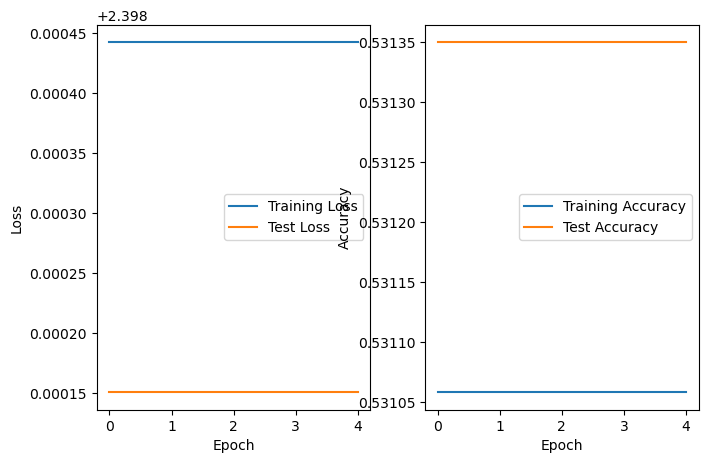

In [41]:
# Построение графиков
plt.figure(figsize=(12, 5))

# График потерь
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# График точности
plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# # График AUC
# plt.subplot(1, 3, 3)
# plt.plot(train_auc_scores, label='Training AUC')
# plt.plot(test_auc_scores, label='Test AUC')
# plt.xlabel('Epoch')
# plt.ylabel('AUC')
# plt.legend()

plt.show()

In [42]:
print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.25
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)


### Оценка модели

In [43]:
# Переведите модель в режим оценки
model.eval()

# Сделайте прогноз на тестовом наборе данных
with torch.no_grad():
    predictions = model(X_val_tensor)
    predictions = torch.nn.functional.softmax(predictions, dim=1)

In [44]:
predictions[100:110]

tensor([[0.0534, 0.0534, 0.0534, 0.0534, 0.0534, 0.0534, 0.0534, 0.0534, 0.0534,
         0.0534, 0.0534, 0.0534, 0.0534, 0.0534, 0.0534, 0.1452, 0.0534],
        [0.0534, 0.0534, 0.0534, 0.0534, 0.0534, 0.0534, 0.0534, 0.0534, 0.0534,
         0.0534, 0.0534, 0.0534, 0.0534, 0.0534, 0.0534, 0.1452, 0.0534],
        [0.0534, 0.0534, 0.0534, 0.0534, 0.0534, 0.0534, 0.0534, 0.0534, 0.0534,
         0.0534, 0.0534, 0.0534, 0.0534, 0.0534, 0.0534, 0.1452, 0.0534],
        [0.0534, 0.0534, 0.0534, 0.0534, 0.0534, 0.0534, 0.0534, 0.0534, 0.0534,
         0.0534, 0.0534, 0.0534, 0.0534, 0.0534, 0.0534, 0.1452, 0.0534],
        [0.0534, 0.0534, 0.0534, 0.0534, 0.0534, 0.0534, 0.0534, 0.0534, 0.0534,
         0.0534, 0.0534, 0.0534, 0.0534, 0.0534, 0.0534, 0.1452, 0.0534],
        [0.0534, 0.0534, 0.0534, 0.0534, 0.0534, 0.0534, 0.0534, 0.0534, 0.0534,
         0.0534, 0.0534, 0.0534, 0.0534, 0.0534, 0.0534, 0.1452, 0.0534],
        [0.0534, 0.0534, 0.0534, 0.0534, 0.0534, 0.0534, 0.0534, 0.053

In [45]:
class_names = ['{other}', '{}', '{α, β}', '{α, γ}', '{α, δ}', '{α, ε, η}',
               '{α, ε, θ}', '{α, ε, ψ}', '{α, ε}', '{α, η}', '{α, θ}', '{α, λ}',
               '{α, μ}', '{α, π}', '{α, ψ}', '{α}', '{λ}']

classes = np.array(class_names, dtype=object)

In [46]:
classes

array(['{other}', '{}', '{α, β}', '{α, γ}', '{α, δ}', '{α, ε, η}',
       '{α, ε, θ}', '{α, ε, ψ}', '{α, ε}', '{α, η}', '{α, θ}', '{α, λ}',
       '{α, μ}', '{α, π}', '{α, ψ}', '{α}', '{λ}'], dtype=object)

In [47]:
def weighted_roc_auc(y_true, y_pred, labels, weights_dict):
    unnorm_weights = np.array([weights_dict[label] for label in labels])
    weights = unnorm_weights / unnorm_weights.sum()
    classes_roc_auc = roc_auc_score(y_true, y_pred, labels=labels,
                                    multi_class="ovr", average=None)
    return sum(weights * classes_roc_auc)

In [48]:
cluster_weights = pd.read_excel("./Alfa_Bank/cluster_weights.xlsx").set_index("cluster")
weights_dict = cluster_weights["unnorm_weight"].to_dict()

In [49]:
weighted_roc_auc(y_val, predictions, classes, weights_dict)

0.5

In [124]:
pip show torch

Name: torch
Version: 2.2.1
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: C:\Users\Lenovo\anaconda3\Lib\site-packages
Requires: filelock, fsspec, jinja2, networkx, sympy, typing-extensions
Required-by: fastai, torchvision
Note: you may need to restart the kernel to use updated packages.


In [130]:
print(torch.version.cuda)

None


In [131]:
torch.cuda.is_available()

False